# Creación del modelo

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import keras

CURRENT_DIR = Path('/content/drive')
from google.colab import drive
drive.mount(str(CURRENT_DIR))

CURRENT_DIR = CURRENT_DIR.joinpath('MyDrive','restauracion')
MODULES_DIR = CURRENT_DIR.joinpath('src')
sys.path.append(str(MODULES_DIR))
DATA_DIR = CURRENT_DIR.joinpath('Process')

%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
from keras.models import Model, load_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Lista de todas las GPUs disponibles en el sistema
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # Si hay al menos una GPU disponible, establecer el uso de solo una GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

    # Limitar la capacidad de la GPU a 10 GB
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12*1024)])  # 10 GB en MB

    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("Usando solo 1 de", len(gpus), "GPU físicas y", len(logical_gpus), "GPU lógicas")
else:
    print("No se encontraron GPUs disponibles.")

Usando solo 1 de 1 GPU físicas y 1 GPU lógicas


In [3]:
x_input, y_input = 1204,1701

----
# Carga de datos

In [4]:
from sklearn.model_selection import train_test_split
from keras.utils import img_to_array, load_img

In [5]:
directories_clean = sorted([f for f in DATA_DIR.joinpath('test').iterdir() if f.is_dir()])
files_clean = []
for folder in directories_clean:
    files_clean = sorted(DATA_DIR.joinpath('test',folder.name).glob('*.jpg')) + files_clean

files_clean = sorted(files_clean)

In [6]:
directories_noisy = sorted([f for f in DATA_DIR.joinpath('train').iterdir() if f.is_dir()])
files_noisy = []
for folder in directories_clean:
    files_noisy = sorted(DATA_DIR.joinpath('train',folder.name).glob('*.jpg')) + files_noisy

files_noisy = sorted(files_noisy)

In [7]:
x_train_list, x_test_list, y_train_list, y_test_list = train_test_split(
    files_noisy,
    files_clean,
    test_size=0.2
)

In [8]:
import data_load

In [9]:
trainning_generator = data_load.CustomImageDataGenerator(
    image_paths_noisy=x_train_list,
    image_paths_clean=y_train_list,
    batch_size=16,
    target_size=(x_input, y_input),
    class_mode='input',
    shuffle=True)


In [10]:
testing_generator = data_load.CustomImageDataGenerator(
    image_paths_noisy=x_test_list,
    image_paths_clean=y_test_list,
    batch_size=16,
    target_size=(x_input, y_input),
    class_mode='input',
    shuffle=True)

-----

# Creación del modelo

In [11]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model, Sequential

In [12]:
input = Input(
    shape=(x_input,y_input, 1),
    name= 'Image_Input')

## Decoder

In [13]:
x = Conv2D(
    filters = 16,
    kernel_size = (3,3),
    activation = 'relu',
    padding = 'same',
    name = 'Convolutional_Layer_1')(input)

x = Conv2D(
    filters = 16,
    kernel_size = (3,3),
    activation = 'relu',
    padding = 'same',
    name = 'Convolutional_Layer_2')(x)


x = BatchNormalization()(x)

## Encoder


In [14]:
decoded = Conv2D(
    filters = 1,
    kernel_size= (3, 3),
    activation='sigmoid',
    padding='same',
    name = 'decoder')(x)


In [15]:
autoencoder = Model(input,decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, 1204, 1701, 1)]   0         
                                                                 
 Convolutional_Layer_1 (Conv  (None, 1204, 1701, 16)   160       
 2D)                                                             
                                                                 
 Convolutional_Layer_2 (Conv  (None, 1204, 1701, 16)   2320      
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 1204, 1701, 16)   64        
 ormalization)                                                   
                                                                 
 decoder (Conv2D)            (None, 1204, 1701, 1)     145       
                                                             

In [16]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae','accuracy'])

In [17]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

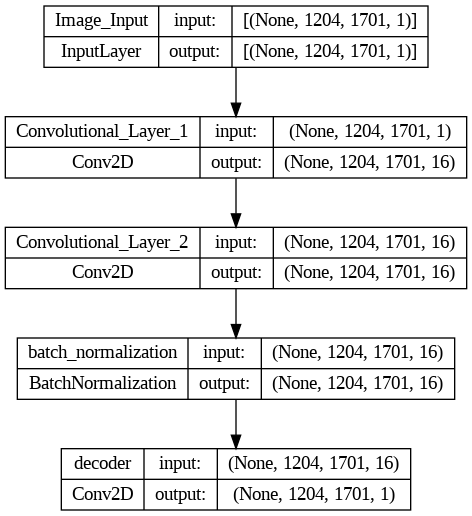

In [18]:
keras.utils.plot_model(autoencoder, "autoencoder_v_0_1.png", show_shapes=True)

------

# Carga del modelo anterior

In [19]:
modelo_previamente_entrenado = load_model(str(DATA_DIR.joinpath('modelo_v_0_1.h5')))
capas_seleccionadas = ['Convolutional_Layer_1']
pesos_seleccionados = [modelo_previamente_entrenado.get_layer(nombre_capa).get_weights() for nombre_capa in capas_seleccionadas]


In [20]:
# Establecer los pesos en el nuevo modelo
for capa, peso in zip(autoencoder.layers[1:], pesos_seleccionados):
    capa.set_weights(peso)

In [21]:
autoencoder.fit(
    trainning_generator,
    epochs=5,
    steps_per_epoch=len(trainning_generator),
    shuffle=True,
    validation_data=testing_generator,
    validation_steps=len(testing_generator)
)

Epoch 1/5
76/76 [==============================] - 1088s 14s/step - loss: 0.0536 - mae: 0.1970 - accuracy: 9.8678e-05 - val_loss: 0.0208 - val_mae: 0.1260 - val_accuracy: 5.2217e-05
Epoch 2/5
76/76 [==============================] - 155s 2s/step - loss: 0.0084 - mae: 0.0519 - accuracy: 1.0152e-04 - val_loss: 0.0164 - val_mae: 0.0996 - val_accuracy: 5.2214e-05
Epoch 3/5
76/76 [==============================] - 155s 2s/step - loss: 0.0071 - mae: 0.0458 - accuracy: 1.0110e-04 - val_loss: 0.0159 - val_mae: 0.0976 - val_accuracy: 5.2217e-05
Epoch 4/5
76/76 [==============================] - 155s 2s/step - loss: 0.0066 - mae: 0.0435 - accuracy: 1.0195e-04 - val_loss: 0.0157 - val_mae: 0.0914 - val_accuracy: 5.2210e-05
Epoch 5/5
76/76 [==============================] - 168s 2s/step - loss: 0.0063 - mae: 0.0409 - accuracy: 1.0129e-04 - val_loss: 0.0148 - val_mae: 0.0909 - val_accuracy: 5.2205e-05


In [22]:
autoencoder.save(str(DATA_DIR.joinpath('modelo_v_0_2.h5')))

-----

Prueba de resultados

In [23]:
x,y = testing_generator.__getitem__(random.randint(0,9))

In [24]:
output1 = autoencoder.predict(x)

1/1 [==============================] - 0s 262ms/step


In [25]:
from tensorflow.keras.preprocessing.image import array_to_img

In [27]:
i = random.randint(0,15)
fig, ax = plt.subplots(3,1, figsize=(15,30))

a1 = array_to_img(np.array(x[i] * 255, dtype=np.uint8))
ax[0].imshow(a1, cmap='gray')
ax[0].set_title('Imagen con defectos')
ax[0].axis(False)

a2 = array_to_img(np.array(y[i] * 255, dtype=np.uint8))
ax[1].imshow(a2,cmap='gray')
ax[1].set_title('Imagen real limpia')
ax[1].axis(False)

a3 = array_to_img(np.array(output1[i] * 255, dtype=np.uint8))
ax[2].imshow(a1,cmap='gray')
ax[2].set_title('Procesada')
ax[2].axis(False)
plt.show()

Output hidden; open in https://colab.research.google.com to view.